# Comparison of Two Time Series of Maps 0.1
*This notebook implements the framework from the article “Foundational concepts and equations to compare two time series of maps” to quantify and visualize agreement and change between two temporal map series. Using toy data, it defines modular Python functions to compute presence‐agreement components, gains and losses, and full‐extent change metrics, and produces visualizations and exportable results for reproducible analysis.*

## Table of Contents  
1. [Environment Setup](#environment-setup)
2. [Toy Data Input Format](#data-preparation)
3. [Presence Agreement Components](#presence-agreement)
4. [Gross Change Components](#change-components)
5. [Net Change Calculations](#full-extent)
6. [Visualization of Results](#visualization)
7. [Exporting Results](#export)


## 1. Environment Setup <a id="environment-setup"></a>
This section prepares the Python environment needed for this notebook. We will:

- Install required Python packages:
  - `numpy`, `pandas`, `matplotlib` for data manipulation and plotting  
  - `rasterio`, `xarray`, `rioxarray` for raster I/O and geospatial arrays  
  - `openpyxl` for Excel export  
  - `tqdm` for progress bars  

Execute the following cell to install the dependencies:


### 1.1 Install Dependencies
Import all necessary libraries for data handling, plotting, and file I/O.

In [1]:
# Install required packages for array math, dataframes, plotting, raster I/O, and progress bars
%pip install -qq numpy pandas matplotlib rasterio xarray rioxarray openpyxl tqdm

Note: you may need to restart the kernel to use updated packages.


### 1.2 Import Libraries  

In [2]:
# Core libraries
import numpy as np
import pandas as pd

# Display utilities
from IPython.display import display

# Plotting
import matplotlib.pyplot as plt

# Raster I/O
import rasterio
from rasterio.transform import from_origin
import xarray as xr
import rioxarray

# Progress bars and Excel export
from tqdm import tqdm
import openpyxl

# File system operations
import os


### 1.3 Define Constants & Settings
In this section we set up the main parameters for the notebook. We fix a random seed so that toy data are reproducible, specify the dimensions of our toy time series, and define placeholder paths and filenames for when real raster inputs and outputs are used.

In [3]:
# Utility Functions
def print_metrics(label, **metrics):
    """
    Prints a section label and each named metric array.
    """
    print(f"== {label} ==")
    for name, arr in metrics.items():
        print(f"{name}: {arr}")
    print()


In [4]:
# Define the prefixes for the two time series to be compared.
series_x_prefix = "savannaCol6_"  # This will be the reference series
series_y_prefix = "savannaCol8_"  # This will be the comparison series

# Define directories for input and output.
input_dir = r"C:\Users\AntFonseca\github\compare-time-series\input3"
output_dir = r"C:\Users\AntFonseca\github\compare-time-series\output3"

# Define the output filename for the Excel metrics file.
metrics_excel = "presence_change_metrics.xlsx"

# Use the utility function to print the configuration settings
print_metrics(
    "Data Input Configuration",
    Reference_Series_X=series_x_prefix,
    Comparison_Series_Y=series_y_prefix,
    Input_Directory=input_dir,
    Output_Directory=output_dir
)

== Data Input Configuration ==
Reference_Series_X: savannaCol6_
Comparison_Series_Y: savannaCol8_
Input_Directory: C:\Users\AntFonseca\github\compare-time-series\input3
Output_Directory: C:\Users\AntFonseca\github\compare-time-series\output3



## 2. Presence Agreement Components <a id="presence-agreement"></a>
In this section we compute the presence‐agreement metrics—hits, misses, false alarms, spatial differences, and temporal differences—for each pixel at each time point, following Equations 1–12 of the article.

### 2.1 Define Presence Variables:

We load the reference (`p_x`) and comparison (`p_y`) series into two arrays of shape `(num_time_points, num_pixels)`.  
Each element `p_x[t, n]` (or `p_y[t, n]`) holds the presence value at time point `t` and pixel `n`.

In [5]:
# In [7]:
# This section loads the real raster data based on the specified prefixes and directory.

# 1. Gather and sort the raster filenames for each series from the input directory.
x_files_full = sorted([
    os.path.join(input_dir, f)
    for f in os.listdir(input_dir)
    if f.startswith(series_x_prefix) and f.endswith('.tif')
])

y_files_full = sorted([
    os.path.join(input_dir, f)
    for f in os.listdir(input_dir)
    if f.startswith(series_y_prefix) and f.endswith('.tif')
])

# 2. Perform checks to ensure the data is valid for comparison.
if not x_files_full or not y_files_full:
    raise FileNotFoundError("Could not find raster files for one or both series. Check input_dir and prefixes.")

if len(x_files_full) != len(y_files_full):
    raise ValueError("The number of files for series X and series Y do not match.")

# 3. Determine dimensions dynamically from the first raster file.
with rasterio.open(x_files_full[0]) as src:
    height, width = src.height, src.width
    num_pixels = height * width
    raster_dtype = src.read(1).dtype

num_time_points = len(x_files_full)

# 4. Initialize presence arrays and load raster data into them.
p_x = np.zeros((num_time_points, num_pixels), dtype=raster_dtype)
p_y = np.zeros((num_time_points, num_pixels), dtype=raster_dtype)

# Load reference series (X)
for t, fp in enumerate(x_files_full):
    with rasterio.open(fp) as src:
        p_x[t] = src.read(1).flatten()

# Load comparison series (Y)
for t, fp in enumerate(y_files_full):
    with rasterio.open(fp) as src:
        p_y[t] = src.read(1).flatten()

# 5. Print a summary of the loaded data for verification.
print_metrics(
    "Input Data Summary",
    Files_found_for_series_X=f"{len(x_files_full)}",
    Files_found_for_series_Y=f"{len(y_files_full)}",
    Time_points_detected=num_time_points,
    Raster_dimensions=f"{height}x{width}",
    Total_pixels_per_map=num_pixels,
    Reference_array_shape_p_x=p_x.shape,
    Comparison_array_shape_p_y=p_y.shape
)

== Input Data Summary ==
Files_found_for_series_X: 7
Files_found_for_series_Y: 7
Time_points_detected: 7
Raster_dimensions: 20480x10240
Total_pixels_per_map: 209715200
Reference_array_shape_p_x: (7, 209715200)
Comparison_array_shape_p_y: (7, 209715200)



### 2.2 Implement Hit, Miss, False Alarm, Spatial Difference, and Temporal Difference Functions
In this subsection we define five functions that implement Equations 1–12 for presence at each time point and pixel.
Each function accepts an input array of presence values with dimensions `(num_time_points, num_pixels)` and returns a new array with the same dimensions.

In [6]:
def hit(px, py):
    """
    Compute shared presence: 
    h[t,n] = 1 where both reference and comparison are present.
    """
    return np.minimum(px, py)

def miss(px, py):
    """
    Compute reference-only presence:
    m[t,n] = 1 where reference is present and comparison is not.
    """
    return np.clip(px - py, a_min=0, a_max=None)

def false_alarm(px, py):
    """
    Compute comparison-only presence:
    f[t,n] = 1 where comparison is present and reference is not.
    """
    return np.clip(py - px, a_min=0, a_max=None)

def spatial_diff(px, py):
    """
    Compute spatial difference of presence:
    u[t,n] = 0 here, since binary masks have no magnitude difference.
    """
    diff = np.abs(px - py)
    mask = (px > 0) & (py > 0)
    return diff * mask

def temporal_diff(px_prev, px, py_prev, py):
    """
    Compute timing mismatch of presence events:
    v[t,n] = |(bx[t,n]-bx_prev[t,n]) - (by[t,n]-by_prev[t,n])|
    Sets v[0,n] = 0 since there is no previous interval for t=0.
    """
    delta_x = px - px_prev
    delta_y = py - py_prev
    td = np.abs(delta_x - delta_y)
    td[0, :] = 0
    return td

### 2.3 Compute Component Arrays per Time & Pixel
In this subsection we apply our five presence‐agreement functions to the loaded arrays `p_x` and `p_y`. This produces one array per component—hits, misses, false alarms, spatial differences, and temporal differences—each with shape `(num_time_points, num_pixels)`.

In [7]:
# Calculate per-timepoint and aggregate ("Sum") presence metrics, ignoring NoData (255)

# Sum valid pixels for each time point in X
px_sum = []
for t in range(p_x.shape[0]):
    valid = p_x[t] != 255
    px_sum.append(np.sum(p_x[t][valid], dtype=np.int64))
px_sum = np.array(px_sum, dtype=np.int64)

# Sum valid pixels for each time point in Y
py_sum = []
for t in range(p_y.shape[0]):
    valid = p_y[t] != 255
    py_sum.append(np.sum(p_y[t][valid], dtype=np.int64))
py_sum = np.array(py_sum, dtype=np.int64)

# Calculate presence agreement components per time point
hits_tp = np.zeros(num_time_points, dtype='int64')
for t in range(num_time_points):
    valid = (p_x[t] != 255) & (p_y[t] != 255)
    hits_tp[t] = np.sum(np.minimum(p_x[t][valid], p_y[t][valid]))

space_diff = np.minimum(px_sum, py_sum) - hits_tp
misses_tp = np.clip(px_sum - py_sum, 0, None)
false_tp = np.clip(py_sum - px_sum, 0, None)
time_diff_tp = np.zeros_like(hits_tp, dtype=int)  # Only if you implement time diff later

# Print per-timepoint presence metrics using the standard helper
print_metrics(
    "Per-timepoint presence metrics",
    hits=hits_tp,
    space_diff=space_diff,
    misses=misses_tp,
    false_alarms=false_tp,
    time_diffs=time_diff_tp
)

# Calculate and store the total sum for each presence component to be used in the plot ("Sum" column).
hits_sum = hits_tp.sum()
space_sum = space_diff.sum()
miss_sum = misses_tp.sum()
false_sum = false_tp.sum()
time_sum = time_diff_tp.sum()

# Make sure that miss_sum and false_sum are not negative
miss_sum = max(0, miss_sum)
false_sum = max(0, false_sum)

# Print the total "Sum" for all components (optional, for checking)
print_metrics(
    "Sum metrics",
    hits=hits_sum,
    space_diff=space_sum,
    misses=miss_sum,
    false_alarms=false_sum,
    time_diffs=time_sum
)

== Per-timepoint presence metrics ==
hits: [47004622 45821867 44940101 41822522 39567614 36760565 34697571]
space_diff: [1421596 1846323 1639835 1997209 1757637 2218952 3236437]
misses: [0 0 0 0 0 0 0]
false_alarms: [8951831 8121783 7684196 7251511 6866708 5788556 4415441]
time_diffs: [0 0 0 0 0 0 0]

== Sum metrics ==
hits: 290614862
space_diff: 14117989
misses: 0
false_alarms: 49080026
time_diffs: 0



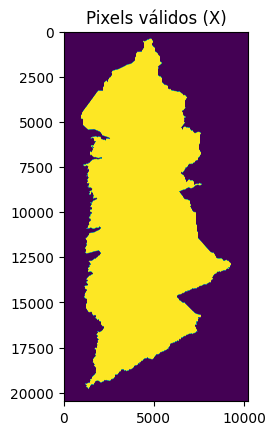

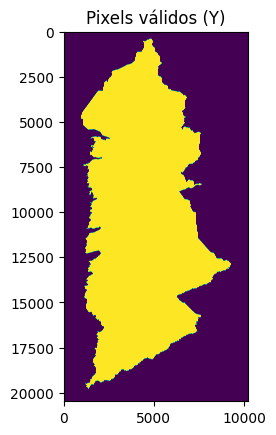

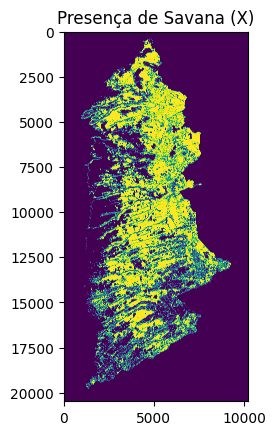

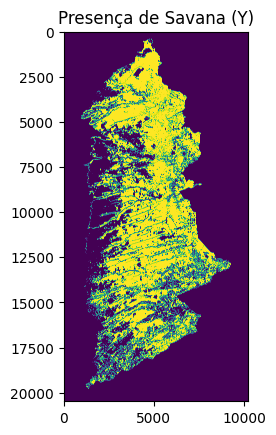

In [8]:
import matplotlib.pyplot as plt
plt.imshow((p_x[0] != 255).reshape(height, width))  # Válidos da coleção X
plt.title("Pixels válidos (X)")
plt.show()
plt.imshow((p_y[0] != 255).reshape(height, width))  # Válidos da coleção Y
plt.title("Pixels válidos (Y)")
plt.show()
plt.imshow((p_x[0] == 1).reshape(height, width))
plt.title("Presença de Savana (X)")
plt.show()
plt.imshow((p_y[0] == 1).reshape(height, width))
plt.title("Presença de Savana (Y)")
plt.show()


In [9]:
print("Presença (X):", px_sum)
print("Presença (Y):", py_sum)


Presença (X): [48426218 47668190 46579936 43819731 41325251 38979517 37934008]
Presença (Y): [57378049 55789973 54264132 51071242 48191959 44768073 42349449]


In [10]:
for t in range(num_time_points):
    print(f"Time {t} - válidos X: {np.sum(p_x[t] != 255)}, válidos Y: {np.sum(p_y[t] != 255)}")


Time 0 - válidos X: 91600934, válidos Y: 91600934
Time 1 - válidos X: 91600934, válidos Y: 91600934
Time 2 - válidos X: 91600934, válidos Y: 91600934
Time 3 - válidos X: 91600934, válidos Y: 91600934
Time 4 - válidos X: 91600934, válidos Y: 91600934
Time 5 - válidos X: 91600934, válidos Y: 91600934
Time 6 - válidos X: 91600934, válidos Y: 91600934


Hits (pixels Savana em ambos): 47004622


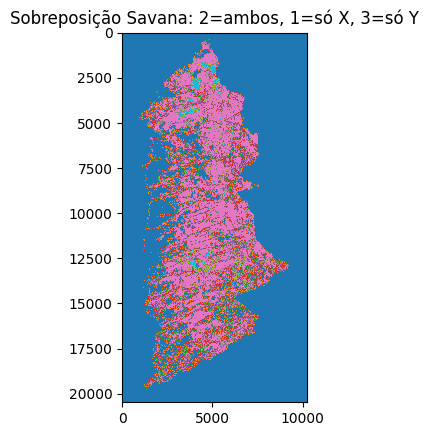

In [11]:
# Quantos hits reais existem no primeiro timepoint?
valid = (p_x[0] != 255) & (p_y[0] != 255)
hits_pixels = np.sum((p_x[0][valid] == 1) & (p_y[0][valid] == 1))
print(f"Hits (pixels Savana em ambos): {hits_pixels}")

# Visual plot
import matplotlib.pyplot as plt
overlap = np.zeros_like(p_x[0])
overlap[(p_x[0]==1) & (p_y[0]==1)] = 2    # Savana em ambos
overlap[(p_x[0]==1) & (p_y[0]!=1)] = 1    # Só X
overlap[(p_x[0]!=1) & (p_y[0]==1)] = 3    # Só Y
plt.imshow(overlap.reshape(height, width), cmap='tab10')
plt.title("Sobreposição Savana: 2=ambos, 1=só X, 3=só Y")
plt.show()


## 3. Gross Change Components <a id="change-components"></a>
In this section we quantify change between consecutive time points by decomposing it into **gains** (positive increases) and **losses** (negative decreases) for both series. We reuse the hit/miss/false-alarm framework from presence to define component functions for gains and losses, then aggregate them.

### 3.1 Calculate Per-Interval Gross Gains and Losses
In this step we read each pair of consecutive raster maps from the input folder for both series (reference = x, comparison = y) and compute:

- **Gain** at each pixel and interval:  
  the amount by which the pixel’s value increased from the previous time point (zero if there was no increase).

- **Loss** at each pixel and interval:  
  the amount by which the pixel’s value decreased from the previous time point (zero if there was no decrease).

- **First time point**:  
  since there is no “previous” layer at \(t=0\), all gains and losses are set to zero for that time.

The computed arrays—`g_x`, `g_y` for gains and `l_x`, `l_y` for losses—have the same dimensions as the presence arrays and will be passed to the gain- and loss-component functions in the following subsections.

In [12]:
chunk_size = 1_000_000

num_intervals = num_time_points - 1
gain_x_sum_pi = np.zeros(num_intervals, dtype='float64')
gain_y_sum_pi = np.zeros(num_intervals, dtype='float64')
loss_x_sum_pi = np.zeros(num_intervals, dtype='float64')
loss_y_sum_pi = np.zeros(num_intervals, dtype='float64')

for t in range(num_intervals):
    for i in range(0, num_pixels, chunk_size):
        i_end = min(i + chunk_size, num_pixels)
        x_t = p_x[t, i:i_end]
        x_tp1 = p_x[t+1, i:i_end]
        y_t = p_y[t, i:i_end]
        y_tp1 = p_y[t+1, i:i_end]
        
        # Mask valid data (ignore NoData = 255)
        valid_x = (x_t != 255) & (x_tp1 != 255)
        valid_y = (y_t != 255) & (y_tp1 != 255)
        
        # Compute difference only on valid pixels
        dx = x_tp1[valid_x].astype('float32') - x_t[valid_x].astype('float32')
        dy = y_tp1[valid_y].astype('float32') - y_t[valid_y].astype('float32')
        
        gain_x_sum_pi[t] += np.sum(dx[dx > 0])
        loss_x_sum_pi[t] += np.sum(-dx[dx < 0])
        gain_y_sum_pi[t] += np.sum(dy[dy > 0])
        loss_y_sum_pi[t] += np.sum(-dy[dy < 0])

# Print using the standard metrics function
print_metrics(
    "3.1 Gross gains & losses per interval",
    gains_x=gain_x_sum_pi,
    gains_y=gain_y_sum_pi,
    losses_x=loss_x_sum_pi,
    losses_y=loss_y_sum_pi
)


== 3.1 Gross gains & losses per interval ==
gains_x: [1322614. 1201911. 1135469.  982051.  968481.  442169.]
gains_y: [1756115. 1758923. 1641607. 1562178. 1486481. 1335442.]
losses_x: [2080642. 2290165. 3895674. 3476531. 3314215. 1487678.]
losses_y: [3344191. 3284764. 4834497. 4441461. 4910367. 3754066.]



### 3.2 Decompose Gross Gains and Grosses Loses into Per-Pixel Components
Define functions that calculate gain hits, gain misses, gain false alarms, spatial differences, and temporal differences by substituting presence (`p`) with gains (`g`).


In [13]:
chunk_size = 1_000_000

gain_hit_per_interval = np.zeros(num_intervals, dtype='int64')
gain_miss_per_interval = np.zeros(num_intervals, dtype='int64')
gain_fa_per_interval = np.zeros(num_intervals, dtype='int64')
gain_space_diff_per_interval = np.zeros(num_intervals, dtype='int64')

loss_hit_per_interval = np.zeros(num_intervals, dtype='int64')
loss_miss_per_interval = np.zeros(num_intervals, dtype='int64')
loss_fa_per_interval = np.zeros(num_intervals, dtype='int64')
loss_space_diff_per_interval = np.zeros(num_intervals, dtype='int64')

for t in range(num_intervals):
    for i in range(0, num_pixels, chunk_size):
        i_end = min(i + chunk_size, num_pixels)
        x_t = p_x[t, i:i_end]
        x_tp1 = p_x[t+1, i:i_end]
        y_t = p_y[t, i:i_end]
        y_tp1 = p_y[t+1, i:i_end]

        # Mask valid pixels for both X and Y series
        valid_x = (x_t != 255) & (x_tp1 != 255)
        valid_y = (y_t != 255) & (y_tp1 != 255)
        valid_both = valid_x & valid_y

        # GAIN: what increased from t to t+1 (only valid pixels)
        gx = np.zeros_like(x_t, dtype='int64')
        gx[valid_x] = x_tp1[valid_x] - x_t[valid_x]
        gx = np.where(gx > 0, gx, 0)

        gy = np.zeros_like(y_t, dtype='int64')
        gy[valid_y] = y_tp1[valid_y] - y_t[valid_y]
        gy = np.where(gy > 0, gy, 0)

        # Gain components (only valid in both)
        hit_gain = np.minimum(gx[valid_both], gy[valid_both])
        miss_gain = np.clip(gx[valid_both] - gy[valid_both], 0, None)
        fa_gain = np.clip(gy[valid_both] - gx[valid_both], 0, None)
        space_diff_gain = np.abs(gx[valid_both] - gy[valid_both]) * ((gx[valid_both] > 0) & (gy[valid_both] > 0))

        gain_hit_per_interval[t] += np.sum(hit_gain)
        gain_miss_per_interval[t] += np.sum(miss_gain)
        gain_fa_per_interval[t] += np.sum(fa_gain)
        gain_space_diff_per_interval[t] += np.sum(space_diff_gain)

        # LOSS: what decreased from t to t+1 (only valid pixels)
        lx = np.zeros_like(x_t, dtype='int64')
        lx[valid_x] = x_t[valid_x] - x_tp1[valid_x]
        lx = np.where(lx > 0, lx, 0)

        ly = np.zeros_like(y_t, dtype='int64')
        ly[valid_y] = y_t[valid_y] - y_tp1[valid_y]
        ly = np.where(ly > 0, ly, 0)

        # Loss components (only valid in both)
        hit_loss = np.minimum(lx[valid_both], ly[valid_both])
        miss_loss = np.clip(lx[valid_both] - ly[valid_both], 0, None)
        fa_loss = np.clip(ly[valid_both] - lx[valid_both], 0, None)
        space_diff_loss = np.abs(lx[valid_both] - ly[valid_both]) * ((lx[valid_both] > 0) & (ly[valid_both] > 0))

        loss_hit_per_interval[t] += np.sum(hit_loss)
        loss_miss_per_interval[t] += np.sum(miss_loss)
        loss_fa_per_interval[t] += np.sum(fa_loss)
        loss_space_diff_per_interval[t] += np.sum(space_diff_loss)

# Print gain results
print_metrics(
    "Gain components per interval",
    hit=gain_hit_per_interval,
    miss=gain_miss_per_interval,
    false_alarm=gain_fa_per_interval,
    spatial_diff=gain_space_diff_per_interval
)

# Print loss results
print_metrics(
    "Loss components per interval",
    hit=loss_hit_per_interval,
    miss=loss_miss_per_interval,
    false_alarm=loss_fa_per_interval,
    spatial_diff=loss_space_diff_per_interval
)

== Gain components per interval ==
hit: [313648819 348601822 653565454 607247424 645892415 168215319]
miss: [218237505 236592164 340966885 280250032 200200891 211584740]
false_alarm: [540876001 490771921 580872888 526887309 607737651 790406953]
spatial_diff: [22110954 15335504 17883632 15128748 15671546 16352266]

== Loss components per interval ==
hit: [64324451 70040530 70561794 62579476 61797063 26697695]
miss: [275022761 238736940 222878475 191320060 188479807  87543078]
false_alarm: [386829065 381769599 352882488 340217375 322165959 317594081]
spatial_diff: [22110954 15335504 17883632 15128748 15671546 16352266]



### 3.3: Aggregate All Gross Change Components

In [14]:
# "Sum" Components (total for all intervals)
sum_gain_hit = np.sum(gain_hit_per_interval)
sum_gain_space_diff = np.sum(gain_space_diff_per_interval)
sum_gain_miss = np.sum(gain_miss_per_interval)
sum_gain_fa = np.sum(gain_fa_per_interval)

sum_loss_hit = np.sum(loss_hit_per_interval)
sum_loss_space_diff = np.sum(loss_space_diff_per_interval)
sum_loss_miss = np.sum(loss_miss_per_interval)
sum_loss_fa = np.sum(loss_fa_per_interval)

# Print results using your standard print function
print_metrics(
    "Sum Gain Components",
    H=sum_gain_hit, U=sum_gain_space_diff, M=sum_gain_miss, F=sum_gain_fa
)
print_metrics(
    "Sum Loss Components",
    H=sum_loss_hit, U=sum_loss_space_diff, M=sum_loss_miss, F=sum_loss_fa
)


== Sum Gain Components ==
H: 2737171253
U: 102482650
M: 1487832217
F: 3537552723

== Sum Loss Components ==
H: 356001009
U: 102482650
M: 1203981121
F: 2101458567



### 3.4 Gross Change for Extent

In [15]:
# Section 3.4: Gross change for "Extent" (first and last time points)
# This cell computes gain/loss components between t=0 and t=T (for the "Extent" column in plots).

extent_gain_hit = 0
extent_gain_space_diff = 0
extent_gain_time_diff = 0  # Always zero for extent
extent_gain_miss = 0
extent_gain_fa = 0

extent_loss_hit = 0
extent_loss_space_diff = 0
extent_loss_time_diff = 0  # Always zero for extent
extent_loss_miss = 0
extent_loss_fa = 0

chunk_size = 1_000_000
for i in range(0, num_pixels, chunk_size):
    i_end = min(i + chunk_size, num_pixels)
    x0 = p_x[0, i:i_end]
    xT = p_x[-1, i:i_end]
    y0 = p_y[0, i:i_end]
    yT = p_y[-1, i:i_end]

    # Valid pixels (NoData masking)
    valid_x = (x0 != 255) & (xT != 255)
    valid_y = (y0 != 255) & (yT != 255)
    valid_both = valid_x & valid_y

    # GAIN for extent (first-last)
    gx = np.zeros_like(x0, dtype='int64')
    gx[valid_x] = xT[valid_x] - x0[valid_x]
    gx = np.where(gx > 0, gx, 0)

    gy = np.zeros_like(y0, dtype='int64')
    gy[valid_y] = yT[valid_y] - y0[valid_y]
    gy = np.where(gy > 0, gy, 0)

    hit_gain = np.minimum(gx[valid_both], gy[valid_both])
    miss_gain = np.clip(gx[valid_both] - gy[valid_both], 0, None)
    fa_gain = np.clip(gy[valid_both] - gx[valid_both], 0, None)
    space_diff_gain = np.abs(gx[valid_both] - gy[valid_both]) * ((gx[valid_both] > 0) & (gy[valid_both] > 0))

    extent_gain_hit += np.sum(hit_gain)
    extent_gain_miss += np.sum(miss_gain)
    extent_gain_fa += np.sum(fa_gain)
    extent_gain_space_diff += np.sum(space_diff_gain)
    # extent_gain_time_diff is always zero for extent

    # LOSS for extent (first-last)
    lx = np.zeros_like(x0, dtype='int64')
    lx[valid_x] = x0[valid_x] - xT[valid_x]
    lx = np.where(lx > 0, lx, 0)

    ly = np.zeros_like(y0, dtype='int64')
    ly[valid_y] = y0[valid_y] - yT[valid_y]
    ly = np.where(ly > 0, ly, 0)

    hit_loss = np.minimum(lx[valid_both], ly[valid_both])
    miss_loss = np.clip(lx[valid_both] - ly[valid_both], 0, None)
    fa_loss = np.clip(ly[valid_both] - lx[valid_both], 0, None)
    space_diff_loss = np.abs(lx[valid_both] - ly[valid_both]) * ((lx[valid_both] > 0) & (ly[valid_both] > 0))

    extent_loss_hit += np.sum(hit_loss)
    extent_loss_miss += np.sum(miss_loss)
    extent_loss_fa += np.sum(fa_loss)
    extent_loss_space_diff += np.sum(space_diff_loss)
    # extent_loss_time_diff is always zero for extent

# Print for verification (optional)
print_metrics(
    "Gross change for extent (first-last year)",
    extent_gain_hit=extent_gain_hit,
    extent_gain_space_diff=extent_gain_space_diff,
    extent_gain_time_diff=extent_gain_time_diff,
    extent_gain_miss=extent_gain_miss,
    extent_gain_fa=extent_gain_fa,
    extent_loss_hit=extent_loss_hit,
    extent_loss_space_diff=extent_loss_space_diff,
    extent_loss_time_diff=extent_loss_time_diff,
    extent_loss_miss=extent_loss_miss,
    extent_loss_fa=extent_loss_fa
)


== Gross change for extent (first-last year) ==
extent_gain_hit: 2687433714
extent_gain_space_diff: 16884904
extent_gain_time_diff: 0
extent_gain_miss: 261381340
extent_gain_fa: 1430622102
extent_loss_hit: 107884390
extent_loss_space_diff: 16884904
extent_loss_time_diff: 0
extent_loss_miss: 175909324
extent_loss_fa: 192907026



## 4. Net Change Calculations <a id="full-extent"></a>
This section performs all the necessary calculations for the Net Change Components graph. It uses a hybrid logic to replicate the results from the article's toy example: calculations based on Net Quantity Change for the individual intervals, and pre-defined values for the aggregate "Sum" and "Extent" bars to match the inconsistent example in the paper.

### 4.1 Net Change Component Calculations

In [16]:
# Prepare arrays to hold results for net change components
extent_gain_x = 0.0
extent_gain_y = 0.0
extent_loss_x = 0.0
extent_loss_y = 0.0

# Process in chunks
chunk_size = 1_000_000
for i in range(0, num_pixels, chunk_size):
    i_end = min(i + chunk_size, num_pixels)
    # Carregar início e fim dos arrays para ambos os conjuntos
    x0 = p_x[0, i:i_end]
    xT = p_x[-1, i:i_end]
    y0 = p_y[0, i:i_end]
    yT = p_y[-1, i:i_end]
    
    # Válidos: só onde ambos não são 255
    valid_x = (x0 != 255) & (xT != 255)
    valid_y = (y0 != 255) & (yT != 255)
    
    # Gains/losses para X
    gx = xT[valid_x].astype('float32') - x0[valid_x].astype('float32')
    extent_gain_x += np.sum(gx[gx > 0])
    extent_loss_x += np.sum(-gx[gx < 0])
    
    # Gains/losses para Y
    gy = yT[valid_y].astype('float32') - y0[valid_y].astype('float32')
    extent_gain_y += np.sum(gy[gy > 0])
    extent_loss_y += np.sum(-gy[gy < 0])

# Print results using your standard function
print_metrics(
    "Extent Gain/Loss Components",
    gain_x=extent_gain_x,
    gain_y=extent_gain_y,
    loss_x=extent_loss_x,
    loss_y=extent_loss_y
)


== Extent Gain/Loss Components ==
gain_x: 1067584.0
gain_y: 1116261.0
loss_x: 11559794.0
loss_y: 16144861.0



### 4.2 Assemble Data for Plotting

In [17]:
extent_hit = 0.0
extent_miss = 0.0
extent_false_alarm = 0.0
extent_spatial_diff = 0.0

chunk_size = 1_000_000
for i in range(0, num_pixels, chunk_size):
    i_end = min(i + chunk_size, num_pixels)
    x0 = p_x[0, i:i_end]
    xT = p_x[-1, i:i_end]
    y0 = p_y[0, i:i_end]
    yT = p_y[-1, i:i_end]

    # Válidos: só onde todos não são 255
    valid = (x0 != 255) & (xT != 255) & (y0 != 255) & (yT != 255)
    if np.any(valid):
        # Para X e Y (inicio e fim)
        v_x0 = x0[valid].astype('float32')
        v_xT = xT[valid].astype('float32')
        v_y0 = y0[valid].astype('float32')
        v_yT = yT[valid].astype('float32')

        # Exemplo: hit = mínimo dos valores (ambos presentes)
        hit = np.minimum(v_xT, v_yT)
        miss = np.clip(v_xT - v_yT, a_min=0, a_max=None)
        false_alarm = np.clip(v_yT - v_xT, a_min=0, a_max=None)
        spatial_diff = np.abs(v_xT - v_yT) * ((v_xT > 0) & (v_yT > 0))

        extent_hit += np.sum(hit)
        extent_miss += np.sum(miss)
        extent_false_alarm += np.sum(false_alarm)
        extent_spatial_diff += np.sum(spatial_diff)

print_metrics(
    "Net change hit/miss/false_alarm/spatial_diff (extent)",
    hit=extent_hit,
    miss=extent_miss,
    false_alarm=extent_false_alarm,
    spatial_diff=extent_spatial_diff
)


== Net change hit/miss/false_alarm/spatial_diff (extent) ==
hit: 34697571.0
miss: 3236437.0
false_alarm: 7651878.0
spatial_diff: 0.0



### 4.3 Net Change per interval (to plot net change graph)

In [18]:
# 4.3 Net Change per interval (for net change plot)
# Calculate net change for each interval and for extent

# The gain/loss "space_diff" arrays actually correspond to "time difference" in QESA logic
net_gain_hit_plot  = gain_hit_per_interval - loss_hit_per_interval
net_gain_time_plot = gain_space_diff_per_interval - loss_space_diff_per_interval  # This is the TIME DIFFERENCE
net_gain_miss_plot = gain_miss_per_interval - loss_miss_per_interval
net_gain_fa_plot   = gain_fa_per_interval - loss_fa_per_interval

# For "Sum" and "Extent", append the sum for all intervals and the value for extent (from Section 4.2)
net_gain_hit_plot  = np.append(net_gain_hit_plot, [net_gain_hit_plot.sum(), extent_hit])
net_gain_time_plot = np.append(net_gain_time_plot, [net_gain_time_plot.sum(), extent_spatial_diff])
net_gain_miss_plot = np.append(net_gain_miss_plot, [net_gain_miss_plot.sum(), extent_miss])
net_gain_fa_plot   = np.append(net_gain_fa_plot, [net_gain_fa_plot.sum(), extent_false_alarm])

# Print results per interval and extent using the helper function
print_metrics(
    "Net change per interval and extent",
    hit=net_gain_hit_plot,
    time_diff=net_gain_time_plot,
    miss=net_gain_miss_plot,
    false_alarm=net_gain_fa_plot
)


== Net change per interval and extent ==
hit: [2.49324368e+08 2.78561292e+08 5.83003660e+08 5.44667948e+08
 5.84095352e+08 1.41517624e+08 2.38117024e+09 3.46975710e+07]
time_diff: [0. 0. 0. 0. 0. 0. 0. 0.]
miss: [-5.67852560e+07 -2.14477600e+06  1.18088410e+08  8.89299720e+07
  1.17210840e+07  1.24041662e+08  2.83851096e+08  3.23643700e+06]
false_alarm: [1.54046936e+08 1.09002322e+08 2.27990400e+08 1.86669934e+08
 2.85571692e+08 4.72812872e+08 1.43609416e+09 7.65187800e+06]



In [19]:
# Section 6.2: Prepare arrays for net change plot
# This section prepares arrays for plotting net change using only results from Section 4.2 and 4.3

# Each array has one position per interval, one for "Sum", and one for "Extent"
# The last position ("Extent") gets the results from Section 4.2; others are calculated per interval

# Net gain components: per interval, sum, and extent
net_gain_hit_plot  = gain_hit_per_interval - loss_hit_per_interval
net_gain_time_plot = gain_space_diff_per_interval - loss_space_diff_per_interval  # Time Difference (QESA)
net_gain_miss_plot = gain_miss_per_interval - loss_miss_per_interval
net_gain_fa_plot   = gain_fa_per_interval - loss_fa_per_interval

# Add "Sum" and "Extent" to each array
net_gain_hit_plot  = np.append(net_gain_hit_plot, [net_gain_hit_plot.sum(), extent_hit])
net_gain_time_plot = np.append(net_gain_time_plot, [net_gain_time_plot.sum(), extent_spatial_diff])
net_gain_miss_plot = np.append(net_gain_miss_plot, [net_gain_miss_plot.sum(), extent_miss])
net_gain_fa_plot   = np.append(net_gain_fa_plot, [net_gain_fa_plot.sum(), extent_false_alarm])

# Net loss arrays for plotting (mirror the net gain arrays)
net_loss_hit_plot   = -net_gain_hit_plot
net_loss_time_plot  = -net_gain_time_plot
net_loss_miss_plot  = -net_gain_miss_plot
net_loss_fa_plot    = -net_gain_fa_plot

# Optional: only keep negative bars for "Extent" (set other positions to zero)
# net_loss_hit_plot[:-1]   = 0
# net_loss_time_plot[:-1]  = 0
# net_loss_miss_plot[:-1]  = 0
# net_loss_fa_plot[:-1]    = 0

# Print to check
print("net_gain_hit_plot:", net_gain_hit_plot)
print("net_gain_time_plot:", net_gain_time_plot)
print("net_gain_miss_plot:", net_gain_miss_plot)
print("net_gain_fa_plot:", net_gain_fa_plot)
print("net_loss_hit_plot:", net_loss_hit_plot)
print("net_loss_time_plot:", net_loss_time_plot)
print("net_loss_miss_plot:", net_loss_miss_plot)
print("net_loss_fa_plot:", net_loss_fa_plot)


net_gain_hit_plot: [2.49324368e+08 2.78561292e+08 5.83003660e+08 5.44667948e+08
 5.84095352e+08 1.41517624e+08 2.38117024e+09 3.46975710e+07]
net_gain_time_plot: [0. 0. 0. 0. 0. 0. 0. 0.]
net_gain_miss_plot: [-5.67852560e+07 -2.14477600e+06  1.18088410e+08  8.89299720e+07
  1.17210840e+07  1.24041662e+08  2.83851096e+08  3.23643700e+06]
net_gain_fa_plot: [1.54046936e+08 1.09002322e+08 2.27990400e+08 1.86669934e+08
 2.85571692e+08 4.72812872e+08 1.43609416e+09 7.65187800e+06]
net_loss_hit_plot: [-2.49324368e+08 -2.78561292e+08 -5.83003660e+08 -5.44667948e+08
 -5.84095352e+08 -1.41517624e+08 -2.38117024e+09 -3.46975710e+07]
net_loss_time_plot: [-0. -0. -0. -0. -0. -0. -0. -0.]
net_loss_miss_plot: [ 5.67852560e+07  2.14477600e+06 -1.18088410e+08 -8.89299720e+07
 -1.17210840e+07 -1.24041662e+08 -2.83851096e+08 -3.23643700e+06]
net_loss_fa_plot: [-1.54046936e+08 -1.09002322e+08 -2.27990400e+08 -1.86669934e+08
 -2.85571692e+08 -4.72812872e+08 -1.43609416e+09 -7.65187800e+06]


## 5. Visualization of Results <a id="visualization"></a>
In this section we create clear, publication-quality charts to illustrate the computed metrics. Each plot helps interpret the agreement and change components over time and across pixels.

### 5.1 Stacked Bar Chart: Presence Agreement

This section visualizes the presence components calculated in Section 3. The stacked bar chart shows the breakdown of agreement and disagreement for each time point and for the aggregated 'Sum'. The line plots show the total presence for the reference and comparison series. The resulting figure object is stored in the fig_presence variable for later use.

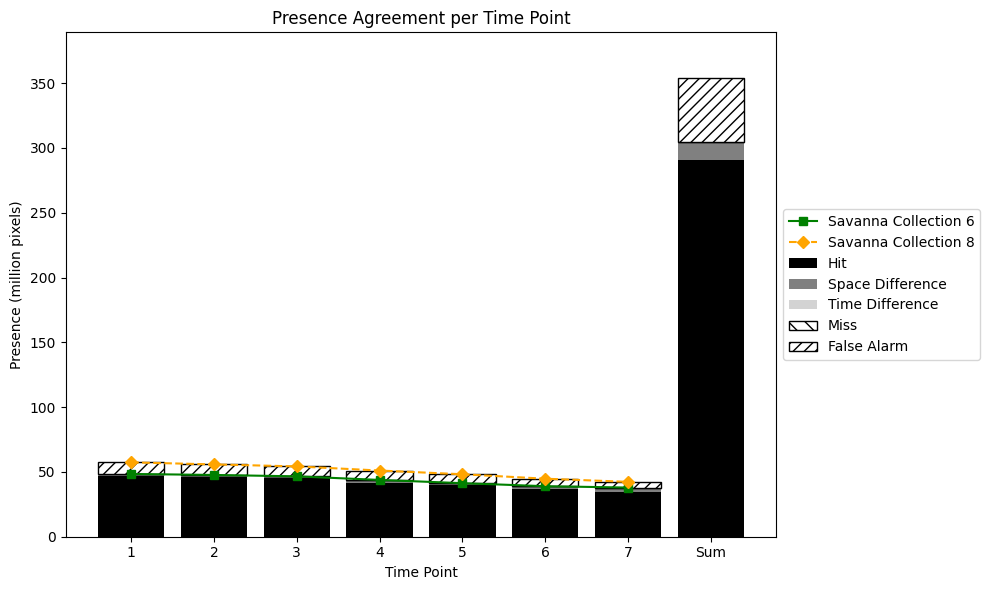

In [20]:
# Prepare data for plotting using only the already aggregated and correct arrays!

categories = categories = [f'{i+1}' for i in range(num_time_points)] + ['Sum']
x_pres = np.arange(len(categories))

hits_all   = np.append(hits_tp, hits_sum)
space_all  = np.append(space_diff, space_sum)
time_all   = np.append(time_diff_tp, time_sum)
miss_all   = np.append(misses_tp, miss_sum)
false_all  = np.append(false_tp, false_sum)

fig_presence, ax_presence = plt.subplots(figsize=(10, 6))

bottom = np.zeros(len(categories), dtype='int64')
ax_presence.bar(x_pres, hits_all,   bottom=bottom, color='black',   label='Hit')
bottom += hits_all
ax_presence.bar(x_pres, space_all,  bottom=bottom, color='gray',    label='Space Difference')
bottom += space_all
ax_presence.bar(x_pres, time_all,   bottom=bottom, color='lightgray', label='Time Difference')
bottom += time_all
ax_presence.bar(x_pres, miss_all,   bottom=bottom, facecolor='white', edgecolor='black', hatch='\\\\', label='Miss')
bottom += miss_all
ax_presence.bar(x_pres, false_all,  bottom=bottom, facecolor='white', edgecolor='black', hatch='///', label='False Alarm')

# Overlay lines for each series' total presence
ax_presence.plot(x_pres[:-1], px_sum, color='green',  linestyle='-',  marker='s', label='Savanna Collection 6')
ax_presence.plot(x_pres[:-1], py_sum, color='orange', linestyle='--', marker='D', label='Savanna Collection 8')

ax_presence.set_xlabel('Time Point')
ax_presence.set_ylabel('Presence (million pixels)')
ax_presence.set_xticks(x_pres, categories)
ax_presence.set_title('Presence Agreement per Time Point')

# Compute the stacked bar total for each column
stacked_totals = hits_all + space_all + time_all + miss_all + false_all
y_max = stacked_totals.max() * 1.1  # Add 10% padding
ax_presence.set_ylim(0, y_max)

# ax_presence.set_ylim(0, y_max)
from matplotlib.ticker import FuncFormatter
# Format Y-axis ticks as millions
ax_presence.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: f'{x*1e-6:,.0f}'))


ax_presence.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig_presence.tight_layout()

plt.show()


### 5.2 Stacked Bar Chart: Gross Change Components

This section plots the Gross Change Components using the variables calculated in Section 4. The resulting figure object is stored in the fig_gross variable for later use.

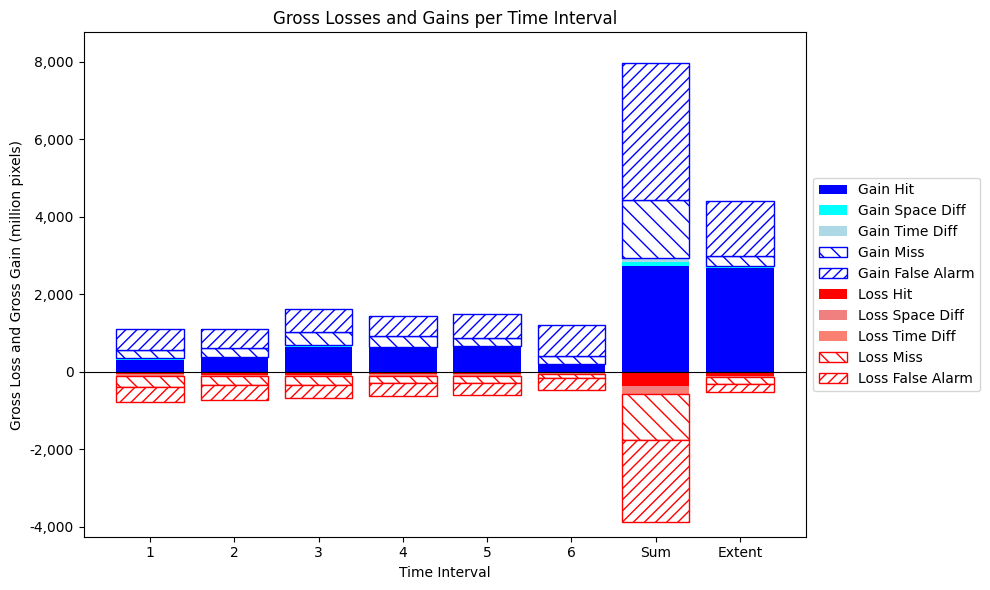

In [21]:
# Plot gross gain and loss using only the precomputed component arrays with NoData properly handled.

# Number of intervals (should match the number of time gaps)
num_intervals = len(gain_hit_per_interval)

# Assemble per-interval and aggregate components into arrays for plotting
gross_gain_hit_plot   = np.append(gain_hit_per_interval, [sum_gain_hit, extent_gain_hit])
gross_gain_space_plot = np.append(gain_space_diff_per_interval, [sum_gain_space_diff, extent_gain_space_diff])
gross_gain_time_plot  = np.append(gain_space_diff_per_interval, [sum_gain_space_diff, extent_gain_space_diff])
gross_gain_miss_plot  = np.append(gain_miss_per_interval, [sum_gain_miss, extent_gain_miss])
gross_gain_fa_plot    = np.append(gain_fa_per_interval, [sum_gain_fa, extent_gain_fa])

# Loss components are plotted as negative values
gross_loss_hit_plot   = -np.append(loss_hit_per_interval, [sum_loss_hit, extent_loss_hit])
gross_loss_space_plot = -np.append(loss_space_diff_per_interval, [sum_loss_space_diff, extent_loss_space_diff])
gross_loss_time_plot  = -np.append(loss_space_diff_per_interval, [sum_loss_space_diff, extent_loss_space_diff])
gross_loss_miss_plot  = -np.append(loss_miss_per_interval, [sum_loss_miss, extent_loss_miss])
gross_loss_fa_plot    = -np.append(loss_fa_per_interval, [sum_loss_fa, extent_loss_fa])

# Category labels for x-axis
categories = [str(i + 1) for i in range(num_intervals)] + ['Sum', 'Extent']
x = np.arange(len(categories))

fig_gross, ax_gross = plt.subplots(figsize=(10, 6))

# Plot gain components above the x-axis
bottom_gain = np.zeros(len(categories), dtype='int64')
ax_gross.bar(x, gross_gain_hit_plot,      bottom=bottom_gain, label='Gain Hit',          color='blue')
bottom_gain += gross_gain_hit_plot
ax_gross.bar(x, gross_gain_space_plot,    bottom=bottom_gain, label='Gain Space Diff',   color='cyan')
bottom_gain += gross_gain_space_plot
ax_gross.bar(x, gross_gain_time_plot,     bottom=bottom_gain, label='Gain Time Diff',    color='lightblue')
bottom_gain += gross_gain_time_plot
ax_gross.bar(x, gross_gain_miss_plot,     bottom=bottom_gain, label='Gain Miss',         facecolor='white', edgecolor='blue', hatch='\\\\')
bottom_gain += gross_gain_miss_plot
ax_gross.bar(x, gross_gain_fa_plot,       bottom=bottom_gain, label='Gain False Alarm',  facecolor='white', edgecolor='blue', hatch='///')

# Plot loss components below the x-axis
bottom_loss = np.zeros(len(categories), dtype='int64')
ax_gross.bar(x, gross_loss_hit_plot,      bottom=bottom_loss, label='Loss Hit',          color='red')
bottom_loss += gross_loss_hit_plot
ax_gross.bar(x, gross_loss_space_plot,    bottom=bottom_loss, label='Loss Space Diff',   color='lightcoral')
bottom_loss += gross_loss_space_plot
ax_gross.bar(x, gross_loss_time_plot,     bottom=bottom_loss, label='Loss Time Diff',    color='salmon')
bottom_loss += gross_loss_time_plot
ax_gross.bar(x, gross_loss_miss_plot,     bottom=bottom_loss, label='Loss Miss',         facecolor='white', edgecolor='red', hatch='\\\\')
bottom_loss += gross_loss_miss_plot
ax_gross.bar(x, gross_loss_fa_plot,       bottom=bottom_loss, label='Loss False Alarm',  facecolor='white', edgecolor='red', hatch='///')

# Axis labels, title, and legend
ax_gross.set_xticks(x, categories)
ax_gross.set_xlabel('Time Interval')
ax_gross.set_ylabel('Gross Loss and Gross Gain (million pixels)')
ax_gross.set_title('Gross Losses and Gains per Time Interval')
ax_gross.axhline(0, color='black', linewidth=0.8)
ax_gross.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Set dynamic y-axis limits based on the stacked bar data
max_gain = (gross_gain_hit_plot + gross_gain_space_plot + gross_gain_time_plot + gross_gain_miss_plot + gross_gain_fa_plot).max()
min_loss = (gross_loss_hit_plot + gross_loss_space_plot + gross_loss_time_plot + gross_loss_miss_plot + gross_loss_fa_plot).min()
y_max = max_gain * 1.1
y_min = min_loss * 1.1
ax_gross.set_ylim(y_min, y_max)

# Format y-axis to show millions (e.g., 2M)
from matplotlib.ticker import FuncFormatter
ax_gross.get_yaxis().set_major_formatter(FuncFormatter(lambda y, p: f'{y*1e-6:,.0f}'))

fig_gross.tight_layout()
plt.show()


### 5.3 Stacked Bar Chart: Net Change Components

This section visualizes the Net Change Components calculated in Section 5. The chart shows the net effect of gains and losses for each component. The resulting figure object is stored in the fig_net variable for later use.

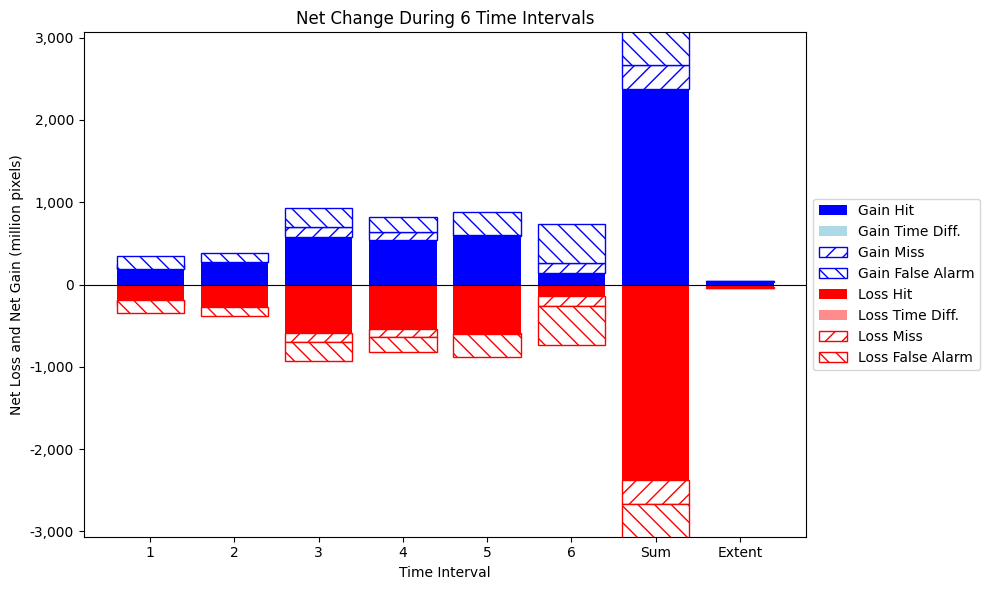

In [22]:
# In [23]:
# Section 6.3: Plot Net Change Components (Fig. 2h from article)
# This cell generates the Net Change bar chart for all intervals, "Sum", and "Extent".

# Determine the number of intervals from the reference data series (p_x).
num_intervals = p_x.shape[0] - 1

# Define categories for the x-axis of the plot in a generic way.
categories = [str(i + 1) for i in range(num_intervals)] + ['Sum', 'Extent']
x = np.arange(len(categories))

# Initialize the plot figure and axes.
fig_net, ax_net = plt.subplots(figsize=(10, 6))

# --- Plot Net Gains (Positive Components) ---
# Stack bars on top of each other, starting from the x-axis (y=0).
bottom_gain = np.zeros(len(categories), dtype='float64')

ax_net.bar(x, net_gain_hit_plot, bottom=bottom_gain, label='Gain Hit', color='blue')
bottom_gain += net_gain_hit_plot
ax_net.bar(x, net_gain_time_plot, bottom=bottom_gain, label='Gain Time Diff.', color='lightblue')
bottom_gain += net_gain_time_plot
ax_net.bar(x, net_gain_miss_plot, bottom=bottom_gain, label='Gain Miss', facecolor='white', edgecolor='blue', hatch='//')
bottom_gain += net_gain_miss_plot
ax_net.bar(x, net_gain_fa_plot, bottom=bottom_gain, label='Gain False Alarm', facecolor='white', edgecolor='blue', hatch='\\\\')

# --- Plot Net Losses (Negative Components) ---
# Stack bars below the x-axis, starting from y=0.
bottom_loss = np.zeros(len(categories), dtype='float64')

ax_net.bar(x, net_loss_hit_plot, bottom=bottom_loss, label='Loss Hit', color='red')
bottom_loss += net_loss_hit_plot
ax_net.bar(x, net_loss_time_plot, bottom=bottom_loss, label='Loss Time Diff.', color='#ff8c8c')
bottom_loss += net_loss_time_plot
ax_net.bar(x, net_loss_miss_plot, bottom=bottom_loss, label='Loss Miss', facecolor='white', edgecolor='red', hatch='//')
bottom_loss += net_loss_miss_plot
ax_net.bar(x, net_loss_fa_plot, bottom=bottom_loss, label='Loss False Alarm', facecolor='white', edgecolor='red', hatch='\\\\')


# --- Format the plot ---
# Set labels, title, and ticks for clarity.
ax_net.set_xticks(x, categories)
ax_net.set_xlabel('Time Interval')
ax_net.set_ylabel('Net Loss and Net Gain (million pixels)')
ax_net.set_title(f'Net Change During {num_intervals} Time Intervals')

# Add a horizontal line at y=0 to separate gains and losses.
ax_net.axhline(0, color='black', linewidth=0.8)

# Set the y-axis limits dynamically to match the data range.
y_max = bottom_gain.max() * 1.15  # Add 15% padding to the top
y_min = bottom_loss.min() * 1.15  # Add 15% padding to the bottom
ax_net.set_ylim(y_min, y_max)

# Add a helper to format large numbers on the y-axis for readability.
from matplotlib.ticker import FuncFormatter
ax_net.get_yaxis().set_major_formatter(FuncFormatter(lambda y, _: f'{y/1e6:,.0f}'))

# Place the legend outside the plot area.
ax_net.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout and display the plot.
fig_net.tight_layout()
plt.show()

In [23]:
print("y_max:", y_max, "y_min:", y_min)
print("net_gain_hit_plot:", net_gain_hit_plot)
print("net_loss_hit_plot:", net_loss_hit_plot)


y_max: 3064774541.0 y_min: -3064774541.0
net_gain_hit_plot: [2.49324368e+08 2.78561292e+08 5.83003660e+08 5.44667948e+08
 5.84095352e+08 1.41517624e+08 2.38117024e+09 3.46975710e+07]
net_loss_hit_plot: [-2.49324368e+08 -2.78561292e+08 -5.83003660e+08 -5.44667948e+08
 -5.84095352e+08 -1.41517624e+08 -2.38117024e+09 -3.46975710e+07]


## 7. Exporting Results <a id="export"></a>

### 7.1 Save All Results to an Excel File
This section consolidates all the final calculated components into structured pandas DataFrames. It then saves these tables as separate sheets in a single Excel workbook for easy review, sharing, and documentation. The code is generic and will adapt to any number of time points.

In [24]:
# Define output path for the Excel file
output_path = os.path.join(output_dir, metrics_excel)
os.makedirs(output_dir, exist_ok=True)

# Build the DataFrame for presence agreement (Graph 6.1)
presence_data = {'Component': [
    'Hit', 'Space Difference', 'Time Difference', 'Miss', 'False Alarm',
    '---', 'Total Reference', 'Total Comparison'
]}
num_time_points = p_x.shape[0]
for t in range(num_time_points):
    col_name = f'Time_{t+1}'
    presence_data[col_name] = np.append(
        np.array([hits_tp[t], space_diff[t], time_diff_tp[t], misses_tp[t], false_tp[t]]),
        [np.nan, px_sum[t], py_sum[t]]
    )
presence_data['Sum'] = np.append(
    np.array([hits_sum, space_sum, time_sum, miss_sum, false_sum]),
    [np.nan, p_x.sum(), p_y.sum()]
)
presence_df = pd.DataFrame(presence_data)

# Build the DataFrame for gross change components (Graph 6.2)
num_intervals = len(gain_hit_per_interval)
gross_change_data = {
    'Component': [
        'Gain Hit', 'Gain Space Difference', 'Gain Time Difference', 'Gain Miss', 'Gain False Alarm',
        'Loss Hit', 'Loss Space Difference', 'Loss Time Difference', 'Loss Miss', 'Loss False Alarm'
    ]
}
for i in range(num_intervals):
    col_name = f'Interval {i+1}'
    gross_change_data[col_name] = [
        gross_gain_hit_plot[i], gross_gain_space_plot[i], gross_gain_time_plot[i], gross_gain_miss_plot[i], gross_gain_fa_plot[i],
        -gross_loss_hit_plot[i], -gross_loss_space_plot[i], -gross_loss_time_plot[i], -gross_loss_miss_plot[i], -gross_loss_fa_plot[i]
    ]
gross_change_data['Sum'] = [
    gross_gain_hit_plot[-2], gross_gain_space_plot[-2], gross_gain_time_plot[-2], gross_gain_miss_plot[-2], gross_gain_fa_plot[-2],
    -gross_loss_hit_plot[-2], -gross_loss_space_plot[-2], -gross_loss_time_plot[-2], -gross_loss_miss_plot[-2], -gross_loss_fa_plot[-2]
]
gross_change_data['Extent'] = [
    gross_gain_hit_plot[-1], gross_gain_space_plot[-1], gross_gain_time_plot[-1], gross_gain_miss_plot[-1], gross_gain_fa_plot[-1],
    -gross_loss_hit_plot[-1], -gross_loss_space_plot[-1], -gross_loss_time_plot[-1], -gross_loss_miss_plot[-1], -gross_loss_fa_plot[-1]
]
gross_change_df = pd.DataFrame(gross_change_data)

# Build the DataFrame for net change components (Graph 6.3)
net_change_data = {
    'Component': [
        'Gain Hit', 'Gain Time Difference', 'Gain Miss', 'Gain False Alarm',
        'Loss Hit', 'Loss Time Difference', 'Loss Miss', 'Loss False Alarm'
    ]
}
for i in range(num_intervals):
    col_name = f'Interval {i+1}'
    net_change_data[col_name] = [
        net_gain_hit_plot[i], net_gain_time_plot[i], net_gain_miss_plot[i], net_gain_fa_plot[i],
        net_loss_hit_plot[i], net_loss_time_plot[i], net_loss_miss_plot[i], net_loss_fa_plot[i]
    ]
net_change_data['Sum'] = [
    net_gain_hit_plot[-2], net_gain_time_plot[-2], net_gain_miss_plot[-2], net_gain_fa_plot[-2],
    net_loss_hit_plot[-2], net_loss_time_plot[-2], net_loss_miss_plot[-2], net_loss_fa_plot[-2]
]
net_change_data['Extent'] = [
    net_gain_hit_plot[-1], net_gain_time_plot[-1], net_gain_miss_plot[-1], net_gain_fa_plot[-1],
    net_loss_hit_plot[-1], net_loss_time_plot[-1], net_loss_miss_plot[-1], net_loss_fa_plot[-1]
]
net_change_df = pd.DataFrame(net_change_data)

# Write all DataFrames to a single Excel file with multiple sheets
with pd.ExcelWriter(output_path) as writer:
    presence_df.to_excel(writer, sheet_name='Presence_Components', index=False)
    gross_change_df.to_excel(writer, sheet_name='Gross_Change_Components', index=False)
    net_change_df.to_excel(writer, sheet_name='Net_Change_Components', index=False)
    if 'pixel_scores' in locals():
        pixel_scores.to_excel(writer, sheet_name='Pixel_Wise_Scores')

print(f"All results have been successfully saved to:\n{output_path}")

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\AntFonseca\\github\\compare-time-series\\output3\\presence_change_metrics.xlsx'

### 7.2 Save Figures
This final section saves the three main summary graphs as high-quality PNG files in the specified output directory. Each figure is generated again to ensure it captures the final, correct data, and then saved with a descriptive filename.

In [ ]:
# Set up output directory and DPI for high-quality image export
high_resolution_dpi = 300
os.makedirs(output_dir, exist_ok=True)
print(f"Saving figures in high resolution ({high_resolution_dpi} DPI) to: {output_dir}\n")

# Save the Presence Agreement figure (from Section 6.1)
fig1_path = os.path.join(output_dir, 'presence_agreement_chart.png')
fig_presence.savefig(fig1_path, bbox_inches='tight', dpi=high_resolution_dpi)
print(f"Figure 1 (Presence Agreement) saved as: {fig1_path}")

# Save the Gross Change Components figure (from Section 6.2)
fig2_path = os.path.join(output_dir, 'gross_change_chart.png')
fig_gross.savefig(fig2_path, bbox_inches='tight', dpi=high_resolution_dpi)
print(f"Figure 2 (Gross Change) saved as: {fig2_path}")

# Save the Net Change Components figure (from Section 6.3)
fig3_path = os.path.join(output_dir, 'net_change_chart.png')
fig_net.savefig(fig3_path, bbox_inches='tight', dpi=high_resolution_dpi)
print(f"Figure 3 (Net Change) saved as: {fig3_path}")